## Init

In [1]:
import os
import sys
from dotenv import load_dotenv
from pathlib import Path

# Dynamically find the project root
project_root_path = Path(os.getcwd()).resolve().parents[1]
dotenv_path = project_root_path / ".env"  # Path to .env

# Load environment variables
load_dotenv(dotenv_path)

sys.path.append(os.path.join(project_root_path, "back_end"))

In [2]:
from app.movie_agent import create_movie_agent

graph = create_movie_agent(with_memory=True)

Attempting to generate and display the graph visualization...


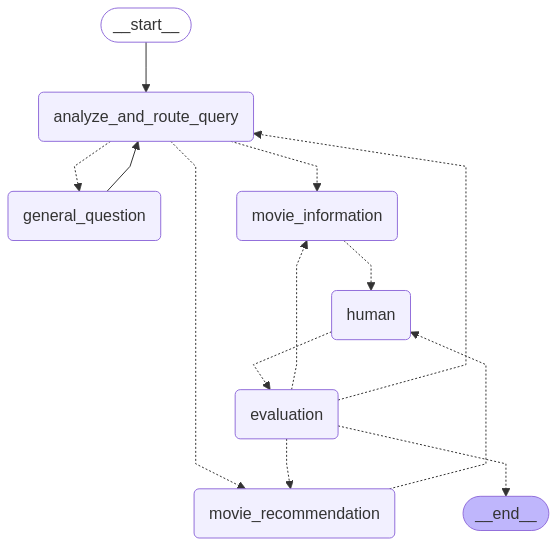

Graph visualization successfully displayed using the default method.
Logging settings restored.


In [3]:
from app.utils import plot_langgraph_graph
plot_langgraph_graph(graph, scale_factor=0.35)

In [4]:
def reset_all_threads(graph):
    """
    Resets all conversations/threads in the given LangGraph graph.

    Args:
        graph: The LangGraph graph instance to reset.
    """
    # Check if the graph has a method to reset its state
    if hasattr(graph, 'reset_state'):
        graph.reset_state()
    else:
        # If no reset method exists, directly set the state to an initial state
        initial_state = {}
        graph.state = initial_state  # Reset the state to the initial state

    # If the graph uses a checkpointer, reset its storage
    if hasattr(graph, 'checkpointer'):
        try:
            graph.checkpointer.storage.clear()  # Clear the storage if it's a dictionary-like structure
        except Exception as e:
            print(e)

    print("All threads have been reset.")

In [5]:
reset_all_threads(graph)

All threads have been reset.


## Process full graph

In [6]:
import uuid
from langgraph.types import Command, interrupt

id = "bdd62e39-8999-468b-be8a-c36277a93bdc"
#id = uuid.uuid4()
thread_config = {"configurable": {"user_id": id, "thread_id": id}}

# Define the human conversation turns
# Case 1: Factual question
# inputs = [
#     "When was the movie Titanic released?",
# ]

# # Case 2: Movie rewiew
# inputs = [
#     "What people think about the movie Titanic? Was it a good movie?",
# ]

# Case 3: Popularit-Ranking
# inputs = [
#     "What are the top 10 movies of all time?",
# ]

# Case 4: Collaborative Filtering
# inputs = [
#     "Suggest me a good action movie.",
# ]

# Case 5: Hybrid Filtering
# inputs = [
#     "I want to see a movie that is similar to Pulp Fiction.",
# ]

inputs = [
    "When was the movie Titanic released?",
    "No, I just want the release date. No other unecessary information.",
    "What is the cast of this movie?",
    "Ok, thank you for the information.",
]

# # Case 7: General conversation
# inputs = [
#     "When was the movie Titanic released?",
#     "What people think about the movie Titanic? Was it a good movie?",
#     "What does the movie Titanic talk about?",
#     "Ok, Thank you for the information. I will watch it.",
# ]

# #Case 8: General conversation
# inputs = [
#     "Suggest me a good action movie.",
#     "Ok, but I do not like Quentin Tarantino movies.",
#     "No, I want something more like Top Gun.",
#     "Ok, perfect!",
# ]

# Format the inputs for the graph
formatted_inputs = []
for idx, user_input in enumerate(inputs):
    if idx == 0:
        # First input is a simple string
        formatted_inputs.append({"messages": [{"role": "user", "content": user_input}]})
    else:
        # Subsequent inputs are wrapped in a Command object
        formatted_inputs.append(Command(resume=user_input))

# Conversation loop
for idx, user_input in enumerate(formatted_inputs):
    print()
    print(f"--- CONVERSATION TURN {idx + 1} ---")
    print()
    # Adjusting user message output
    if isinstance(user_input, dict):
        # Handle standard messages
        for message in user_input.get("messages", []):
            print(f"USER [Message]: {message['content']}")
    elif isinstance(user_input, Command):
        # Handle resume commands
        print(f"USER [Resume]: {user_input.resume}")
    print()
    async for update in graph.astream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                messages = value["messages"]
                ai_messages = []
                # Iterate in reverse order
                for msg in reversed(messages):
                    if type(msg).__name__ == "HumanMessage":
                        # Stop collecting if we encounter a HumanMessage
                        break
                    if type(msg).__name__ == "AIMessage":
                        ai_messages.append(msg.content)
                
                # Reverse collected AI messages back to original order
                ai_messages.reverse()

                if ai_messages:
                    print(f"AI [{node_id}] (messages):")
                    for ai_msg in ai_messages:
                        print(f"\t{ai_msg}")

# End of conversation loop
print("Goodbye! Have a nice day!")


--- CONVERSATION TURN 1 ---

USER [Message]: When was the movie Titanic released?



> Entering new QueryAnalyzerAgent chain...
Thought: I have analyzed the user's query and can now respond.
Final Answer: ```json
{
  "messages": ["I understand you're asking about the release date of the movie Titanic."],
  "route": "movie_information"
}
```

> Finished chain.

Modality: DEBUG
STATE DETAILS in node function: "analyze_and_route_query"
Message History:
	HumanMessage (content): When was the movie Titanic released?
	AIMessage (content): I understand you're asking about the release date of the movie Titanic.
----------------------------------------------------------------------------------------
Fields:
	new_user_movie_ratings: []
	information: {}
	recommended_movies_df: Empty DataFrame
Columns: []
Index: []
	movies: []
	explanations: {}
	report: []
	is_user_satisfied: False
	has_user_other_questions: False
	user_preferences: []
	mood: []

AI [analyze_and_route_query] (messages):
	I underst

## Process full graph with CLI

In [7]:
import uuid
import asyncio
from langgraph.types import Command, interrupt

id = "bdd62e39-8999-468b-be8a-c36277a93bdc"
#id = uuid.uuid4()
thread_config = {"configurable": {"user_id": id, "thread_id": id}}

def get_user_input():
    """
    Prompts the user for input from the command line.
    """
    user_input = input("User: ").strip()
    return user_input

async def main():
    print("\nWelcome, I'm your personal assistant!")
    print("Ask me anything, and I'll provide real-time answers.")
    print("Type 'exit', 'quit', or 'q' to quit.\n")

    is_first_turn = True
    idx = 0

    while True:
        # Get user input
        user_input_str = get_user_input()

        if user_input_str.lower() in ["quit", "exit", "q"]:
            print("Goodbye! Have a great day!")
            break

        if not user_input_str:
            print("[System]: Please enter a valid question!")
            continue

        # Process input based on whether it's the first turn or subsequent turns
        if is_first_turn:
            # First turn: Send as a standard message dictionary
            processed_input = {"messages": [{"role": "user", "content": user_input_str}]}
            is_first_turn = False # Set flag to false after the first turn
        else:
            # Subsequent turns: Send as a Command(resume=...)
            processed_input = Command(resume=user_input_str)

        # Print conversation turn info and user input in the correct format
        print(f"\n--- CONVERSATION TURN {idx + 1} ---")
        if isinstance(processed_input, dict):
             print(f"USER [Message]: {processed_input['messages'][0]['content']}\n")
        elif isinstance(processed_input, Command):
             print(f"USER [Resume]: {processed_input.resume}\n")

        # Stream the graph execution
        async for update in graph.astream(
            processed_input,
            config=thread_config,
            stream_mode="updates",
        ):
            for node_id, value in update.items():
                if isinstance(value, dict) and value.get("messages", []):
                    messages = value["messages"]
                    ai_messages = []
                    # Iterate in reverse order to get the latest AI messages since the last HumanMessage
                    for msg in reversed(messages):
                        if type(msg).__name__ == "HumanMessage":
                            break # Stop when we hit the last human message
                        if type(msg).__name__ == "AIMessage":
                            ai_messages.append(msg.content)
                    
                    # Reverse collected AI messages back to chronological order
                    ai_messages.reverse()

                    if ai_messages:
                        print(f"AI [{node_id}] (AI messages):")
                        for ai_msg in ai_messages:
                            print(f"\t{ai_msg}")
        
        idx += 1 # Increment the conversation turn index

# Run the main function
# await main()